In [1]:
from env import my_setup
my_setup()


import os
from pydataset import data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
from scipy import stats
from env import gdb
from env import Percent
from env import output_chi2_contingency
    


In [2]:
import os
from pydataset import data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
from scipy import stats
from env import gdb
from env import Percent
import acquire
import prepare

# Exercises
Do your work for this exercise in a jupyter notebook or python script named `tidy_data`. Save this work in your `classification-exercises` repo. Add, commit, and push your changes.

## 1. Attendance Data

Read the data from the attendance table and calculate an attendance percentage for each student. One half day is worth 50% of a full day, and 10 tardies is equal to one absence.

You should end up with something like this:

<div class="alert alert-block alert-success">
  >> name<br>
  > Billy <tab>   0.5250<br>
  > Jane     0.6875<br>
  > John     0.9125<br>
  > Sally    0.7625<br>
  > Name: grade, dtype: float64<br>
<br>
</div>

In [20]:
attendance_df = gdb('tidy_data',
                    '''
                    SELECT * FROM attendance
                    '''
                   )

In [21]:
attendance_df

,Unnamed: 0,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08
0,Sally,P,T,T,H,P,A,T,T
1,Jane,A,P,T,T,T,T,A,T
2,Billy,A,T,A,A,H,T,P,T
3,John,P,T,H,P,P,T,P,P


In [22]:
# let's change the 'unnamed: 0' column to 'name'
attendance_df = attendance_df.rename(columns={'Unnamed: 0': 'name'})

In [23]:
# Now we'll melt on 'name' changing the columns—var_name to 'date', and values to the acronym 'path'
attendance_df = attendance_df.melt(id_vars='name', var_name='date', value_name='path')

In [24]:
# take a look
attendance_df

,name,date,path
0,Sally,2018-01-01,P
1,Jane,2018-01-01,A
2,Billy,2018-01-01,A
3,John,2018-01-01,P
4,Sally,2018-01-02,T
5,Jane,2018-01-02,P
6,Billy,2018-01-02,T
7,John,2018-01-02,T
8,Sally,2018-01-03,T
9,Jane,2018-01-03,T


### Now we'll make a mask 
for each of the values in `'path'` and change each to a string with the corresponding values
  * Present = P = '1'
  * Absent  = A = '0'
  * Tardy   = T = '.9'
  * Half-day = H = '.5'

In [ ]:
# attendance_df.path.map({'P':1, 'A': 0, 'T': .9, 'H':.5})

# This works better than string comprehension

In [25]:
mask = attendance_df.path.str.startswith('P')

attendance_df.loc[mask, 'path'] = '1'

#### But why not as a float?
  * Becuase running the `.str` evaluation on the `float`'s will result in `NaN`'s in our mask in addition to `True`/`False`... which breaks

In [27]:
mask = attendance_df.path.str.startswith('A')

attendance_df.loc[mask, 'path'] = '0'

In [28]:
mask = attendance_df.path.str.startswith('T')

attendance_df.loc[mask, 'path'] = '.9'

In [29]:
mask = attendance_df.path.str.startswith('H')

attendance_df.loc[mask, 'path'] = '.5'

In [33]:
# Now that we've finished the .str evaluations we can recast as float
attendance_df.path = attendance_df.path.astype(float)

In [35]:
pd.pivot_table(attendance_df, values='path', index='name')
# automatically —> aggfunc: 'AggFuncType' = 'mean',

,path
name,
Billy,0.5250
Jane,0.6875
John,0.9125
Sally,0.7625


# 2. Coffee Levels

##  - a. Read the coffee_levels table.

In [36]:
coffee_df = gdb('tidy_data',
    '''
    SELECT * FROM coffee_levels
    '''
   )
coffee_df

,hour,coffee_carafe,coffee_amount
0,8,x,0.816164
1,9,x,0.451018
2,10,x,0.843279
3,11,x,0.335533
4,12,x,0.898291
5,13,x,0.310711
6,14,x,0.507288
7,15,x,0.215043
8,16,x,0.183891
9,17,x,0.391560


<AxesSubplot:xlabel='hour', ylabel='coffee_amount'>

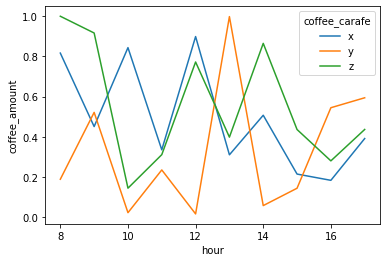

In [101]:
sns.lineplot(data=coffee_df, x='hour', y='coffee_amount', hue='coffee_carafe')

##  - b. Transform the data so that each carafe is in it's own column.

In [93]:
carafe_df = pd.pivot_table(coffee_df,index='hour', columns='coffee_carafe').reset_index()
carafe_df

hour coffee_amount                    
coffee_carafe                  x         y         z
0                8      0.816164  0.189297  0.999264
1                9      0.451018  0.521502  0.915990
2               10      0.843279  0.023163  0.144928
3               11      0.335533  0.235529  0.311495
4               12      0.898291  0.017009  0.771947
5               13      0.310711  0.997464  0.398520
6               14      0.507288  0.058361  0.864464
7               15      0.215043  0.144644  0.436364
8               16      0.183891  0.544676  0.280621
9               17      0.391560  0.594126  0.436677

In [88]:
# carafe_df.columns = carafe_df.columns.droplevel()

In [102]:
carafe_df.melt(id_vars='hour')

,hour,None,coffee_carafe,value
0,8,coffee_amount,x,0.816164
1,9,coffee_amount,x,0.451018
2,10,coffee_amount,x,0.843279
3,11,coffee_amount,x,0.335533
4,12,coffee_amount,x,0.898291
5,13,coffee_amount,x,0.310711
6,14,coffee_amount,x,0.507288
7,15,coffee_amount,x,0.215043
8,16,coffee_amount,x,0.183891
9,17,coffee_amount,x,0.391560


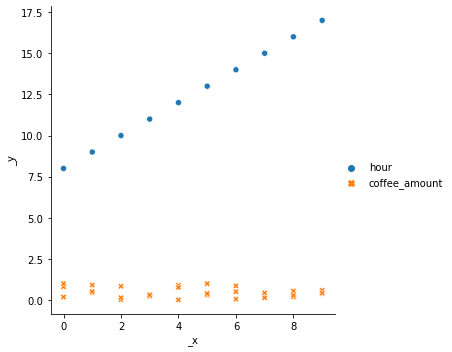

In [96]:
sns.relplot(data=carafe_df)

##  - c. Is this the best shape for the data?

### I guess it depends on what we're looking for...

In [78]:
# coffee_pivot = 
pd.pivot_table(coffee_df,index='hour', columns='coffee_carafe').T.reset_index()
# coffee_pivot

hour,level_0,coffee_carafe,8,9,10,11,12,13,14,15,16,17
0,coffee_amount,x,0.816164,0.451018,0.843279,0.335533,0.898291,0.310711,0.507288,0.215043,0.183891,0.391560
1,coffee_amount,y,0.189297,0.521502,0.023163,0.235529,0.017009,0.997464,0.058361,0.144644,0.544676,0.594126
2,coffee_amount,z,0.999264,0.915990,0.144928,0.311495,0.771947,0.398520,0.864464,0.436364,0.280621,0.436677


In [74]:
coffee_pivot

hour                               8         9         10        11        12  \
              coffee_carafe                                                     
coffee_amount x              0.816164  0.451018  0.843279  0.335533  0.898291   
              y              0.189297  0.521502  0.023163  0.235529  0.017009   
              z              0.999264  0.915990  0.144928  0.311495  0.771947   

hour                               13        14        15        16        17  
              coffee_carafe                                                    
coffee_amount x              0.310711  0.507288  0.215043  0.183891  0.391560  
              y              0.997464  0.058361  0.144644  0.544676  0.594126  
              z              0.398520  0.864464  0.436364  0.280621  0.436677

# 3.  Cake Recipes

  - a. Read the cake_recipes table. This data set contains cake tastiness scores for combinations of different recipes, oven rack positions, and oven temperatures.

In [49]:
cake_df = gdb('tidy_data',
              '''
              SELECT * FROM cake_recipes
              '''
             )
cake_df

,recipe:position,225,250,275,300
0,a:bottom,61.738655,53.912627,74.414730,98.786784
1,a:top,51.709751,52.009735,68.576858,50.228470
2,b:bottom,57.095320,61.904369,61.196980,99.248541
3,b:top,82.455004,95.224151,98.594881,58.169349
4,c:bottom,96.470207,52.001358,92.893227,65.473084
5,c:top,71.306308,82.795477,92.098049,53.960273
6,d:bottom,52.799753,58.670419,51.747686,56.183110
7,d:top,96.873178,76.101363,59.571620,50.971626


##  - b. Tidy the data as necessary.

In [50]:
cake_melt = cake_df.melt(id_vars='recipe:position', var_name='temp', value_name='score')
cake_melt

,recipe:position,temp,score
0,a:bottom,225,61.738655
1,a:top,225,51.709751
2,b:bottom,225,57.095320
3,b:top,225,82.455004
4,c:bottom,225,96.470207
5,c:top,225,71.306308
6,d:bottom,225,52.799753
7,d:top,225,96.873178
8,a:bottom,250,53.912627
9,a:top,250,52.009735


In [51]:
# sales_melt[['year', 'measure']] = sales_melt.variable.str.split(' ', expand = True)
cake_melt[['recipe', 'position']] = cake_melt['recipe:position'].str.split(':', expand = True)
cake_melt

,recipe:position,temp,score,recipe,position
0,a:bottom,225,61.738655,a,bottom
1,a:top,225,51.709751,a,top
2,b:bottom,225,57.095320,b,bottom
3,b:top,225,82.455004,b,top
4,c:bottom,225,96.470207,c,bottom
5,c:top,225,71.306308,c,top
6,d:bottom,225,52.799753,d,bottom
7,d:top,225,96.873178,d,top
8,a:bottom,250,53.912627,a,bottom
9,a:top,250,52.009735,a,top


##  - c. Which recipe, on average, is the best? recipe b

In [52]:
cake_melt.score = cake_melt.score.astype(float)

In [98]:
cake_melt.groupby('recipe').score.mean()\
[cake_melt.groupby('recipe').score.mean() == cake_melt.groupby('recipe').score.mean().max()]


recipe
b    76.736074
Name: score, dtype: float64

In [105]:
cake_melt.groupby('recipe').score.mean().idxmax()

'b'

In [106]:
cake_melt.groupby('recipe').score.mean().max()

76.73607424644435

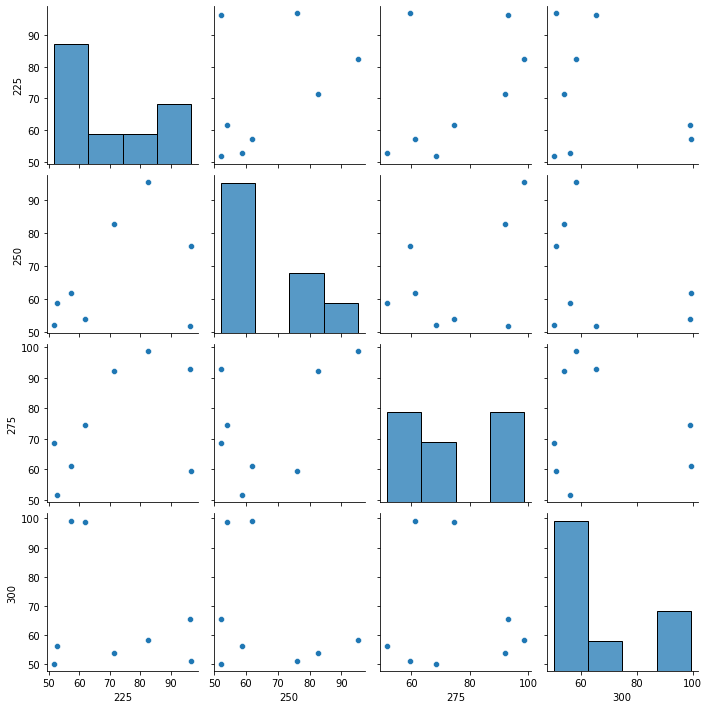

In [109]:
sns.pairplot(data=cake_df)

##  - d. Which oven temperature, on average, produces the best results? 275

In [57]:
cake_melt.groupby('temp').score.mean()

temp
225    71.306022
250    66.577437
275    74.886754
300    66.627655
Name: score, dtype: float64

##  - e. Which combination of recipe, rack position, and temperature gives the best result? recipe b, bottom rack, 300 degrees

In [61]:
cake_melt[cake_melt.score == cake_melt.score.max()]

,recipe:position,temp,score,recipe,position
26,b:bottom,300,99.248541,b,bottom


4. Bonus: explore the other tables in the tidy_data database and reshape them as necessary so that they are in a tidy format.